## The Effects of Spin Rate on a MLB Pitcher's Performance: A Case Study on the 2015 - 2023 Seasons

Hello, welcome to my website! In this Jupyter page, I will be describing the correlation that spin rate has on a variety of different analytics for pitchers throughout the last several years. 

The first thing we need to do is to import "packages" which allow us to gather and collect data. I learned about these packages, along with a bunch of other coding mechanics throughout this page, via an online course by the University of Michigan titled "Foundations of Sports Analytics: Data, Representation, and Models in Sports".

In [1]:
# normal imports
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

Here, we're importing a specific piece of the pybaseball dataset, specifically concerning spin rate. The years are set from 2015 (the start of the StatCast Eram) to 2023 (the current year as of typing this), and the minimum amount of plate appearances against the pitcher is set to 100. I also created a custom formula to derive the specific variables I wanted to study. Those variables are listed on the columns below. 

In [2]:
# pybaseball
from pybaseball import statcast_pitcher_pitch_spin

data_spin_all = statcast_pitcher_pitch_spin('2023,2022,2021,2020,2019,2018,2017,2016,2015', minP=100)
print(data_spin_all.columns.tolist())
data_spin_all

/Users/andrew/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


['last_name', 'first_name', 'player_id', 'year', 'k_percent', 'bb_percent', 'p_era', 'batting_avg', 'exit_velocity_avg', 'whiff_percent', 'groundballs_percent', 'flyballs_percent', 'popups_percent', 'fastball_avg_spin', 'breaking_avg_spin', 'n_breaking_formatted', 'offspeed_avg_spin', 'n_offspeed_formatted']


,last_name,first_name,player_id,year,k_percent,bb_percent,p_era,batting_avg,exit_velocity_avg,whiff_percent,groundballs_percent,flyballs_percent,popups_percent,fastball_avg_spin,breaking_avg_spin,n_breaking_formatted,offspeed_avg_spin,n_offspeed_formatted
0,Colon,Bartolo,112526,2015,16.7,2.9,4.16,0.281,88.9,14.4,44.1,23.2,5.7,2161,2164.0,10.0,1727.0,7.4
1,Hawkins,LaTroy,115629,2015,21.0,4.3,3.26,0.286,89.7,17.0,55.4,18.2,5.8,2051,2072.0,16.6,1698.0,8.0
2,Wolf,Randy,150116,2015,17.4,9.3,6.23,0.319,89.0,16.2,46.2,17.9,5.1,2032,2176.0,40.2,1669.0,11.1
3,Marquis,Jason,150302,2015,17.1,6.5,6.46,0.330,90.4,21.3,48.8,17.1,3.7,1782,1977.0,19.4,1239.0,21.2
4,Burnett,A.J.,150359,2015,20.5,7.0,3.18,0.275,89.8,21.1,55.0,14.1,4.0,2009,2023.0,29.4,1678.0,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,Woo,Bryan,693433,2023,25.9,7.3,4.75,0.242,87.2,27.8,38.8,28.9,7.9,2179,2358.0,11.8,1713.0,3.6
4310,Elder,Bryce,693821,2023,17.7,7.7,3.64,0.245,89.8,23.3,52.9,20.4,4.5,1999,2394.0,36.4,2031.0,12.3
4311,Pfaadt,Brandon,694297,2023,20.5,6.6,6.91,0.303,90.4,24.6,34.1,30.1,8.5,2445,2667.0,32.9,1946.0,14.7
4312,Shuster,Jared,694363,2023,13.0,11.4,5.00,0.250,89.8,21.3,35.2,29.0,12.4,2136,2204.0,34.2,1492.0,21.7


A huge part of this entire study is that I want to isolate both the fastball's average spin rate and also the secondary pitch's spin rate. However, there are three types of pitches listed on pybaseball: fastballs, breaking balls, and offspeed. To simplify things, I wanted to group both breaking balls and offspeed together. When originally looking at them separately, I noticed a high amount of outliers, in that some pitchers threw a pitch labeled as "offspeed" with a lot more spin than typically seen by anyone else's pitches deemed that type. Because of this, I created a formula to group together these 2 pitch types by taking the total percent of both pitch types, and then from there, determined the percent each type was thrown out of the secondary pitches by using the new percent as the total (eliminating fastballs from the percentage), and multiplied that percent by the average spin of that pitch type. From there, I then added both of those numbers (breaking % x breaking spin + offspeed % x offspeed spin) to determine the exact average spin rate of a secondary pitch thrown by a pitcher, now labeled as "Pitch 2".

In [3]:
# massage data - change NaN values to zero, formula to calculate secondary pitch average spin based on pitch usage percentages
data_spin_all = data_spin_all.fillna(0)
data_spin_all["pitch2_avg_spin"] = (data_spin_all['n_breaking_formatted'] / (data_spin_all['n_breaking_formatted'] + data_spin_all['n_offspeed_formatted']) * data_spin_all['breaking_avg_spin']) + \
                                   (data_spin_all['n_offspeed_formatted'] / (data_spin_all['n_breaking_formatted'] + data_spin_all['n_offspeed_formatted']) * data_spin_all['offspeed_avg_spin'])

# change NaN to zero again (formula output to handle pitchers with no secondary pitches)
data_spin_all = data_spin_all.fillna(0)
data_spin_all["pitch2_avg_spin"] = data_spin_all["pitch2_avg_spin"].astype('int')
data_spin_all = data_spin_all.drop(columns=['player_id','breaking_avg_spin','offspeed_avg_spin','n_breaking_formatted','n_offspeed_formatted'])
data_spin_all

,last_name,first_name,year,k_percent,bb_percent,p_era,batting_avg,exit_velocity_avg,whiff_percent,groundballs_percent,flyballs_percent,popups_percent,fastball_avg_spin,pitch2_avg_spin
0,Colon,Bartolo,2015,16.7,2.9,4.16,0.281,88.9,14.4,44.1,23.2,5.7,2161,1978
1,Hawkins,LaTroy,2015,21.0,4.3,3.26,0.286,89.7,17.0,55.4,18.2,5.8,2051,1950
2,Wolf,Randy,2015,17.4,9.3,6.23,0.319,89.0,16.2,46.2,17.9,5.1,2032,2066
3,Marquis,Jason,2015,17.1,6.5,6.46,0.330,90.4,21.3,48.8,17.1,3.7,1782,1591
4,Burnett,A.J.,2015,20.5,7.0,3.18,0.275,89.8,21.1,55.0,14.1,4.0,2009,1943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,Woo,Bryan,2023,25.9,7.3,4.75,0.242,87.2,27.8,38.8,28.9,7.9,2179,2207
4310,Elder,Bryce,2023,17.7,7.7,3.64,0.245,89.8,23.3,52.9,20.4,4.5,1999,2302
4311,Pfaadt,Brandon,2023,20.5,6.6,6.91,0.303,90.4,24.6,34.1,30.1,8.5,2445,2444
4312,Shuster,Jared,2023,13.0,11.4,5.00,0.250,89.8,21.3,35.2,29.0,12.4,2136,1927


After attaining the formula, I then needed to run a linear regression test on the entire data-sheet to view the correlation between both Fastball Spin and Pitch 2 Spin and all of the other variables listed above (K%, BB%, etc.). When running a linear regression test, a lot of information is given, but in this case, the only thing that is needed to determine the correlation is the p-value. Therefore, I coded this section so that the output below would only show the necessary p-values, and no other non-essential information would be included. When the p-value is below 0.05, it means that there is a correlation between the two variables. As shown below, there are a vast number of these statistics that have p-values below 0.05, meaning that there IS a correlation between a lot of these statistics and the average spin of both fastballs and secondary pitches.  

In [4]:
# calculate p-value per year

from scipy.stats import pearsonr

# method to use for 'corr' function to return p-value
# https://stackoverflow.com/questions/52741236/how-to-calculate-p-values-for-pairwise-correlation-of-columns-in-pandas
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

# change settings for prettier output of p-value correlations
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# list of years to cycle through for finding specific year p-values
years = [2023,2022,2021,2020,2019,2018,2017,2016,2015]

# all years
with pd.option_context('display.float_format', '{:0.6f}'.format):
    data_spin_pv = data_spin_all.drop(columns=['last_name', 'first_name', 'year'])
    corr = data_spin_pv.corr(method=pearsonr_pval,numeric_only=True)
    print("All Years\n{}\n".format(corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])]))

# individual years
for y in years:
    with pd.option_context('display.float_format', '{:0.6f}'.format):
        data_spin_year = data_spin_all.loc[data_spin_all['year'] == y]
        data_spin_pv = data_spin_year.drop(columns=['last_name', 'first_name', 'year'])
        corr = data_spin_pv.corr(method=pearsonr_pval,numeric_only=True)
        corr2 = corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])]
        print("\n{}: P-Values\n{}\n".format(y,corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])]))
        # just print the statistically significant correlations (< 0.05)
        corr2 = corr2[corr2 < .05].unstack().transpose()\
            .sort_values( ascending=True).dropna()
        print(corr2)
        # try out printing a p-value heatmap to visualize correlations; decided not to use this :) 
        # plt.figure(figsize=(6,4))
        # sns.set(font_scale=.8)
        # sns.heatmap(corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])].transpose(),annot=True, cmap="YlGnBu",annot_kws={"size": 8},fmt='.4f')
        # plt.title('P-Value Heatmap - {}'.format(y))

All Years
                   k_percent  bb_percent    p_era  batting_avg  exit_velocity_avg  whiff_percent  groundballs_percent  flyballs_percent  popups_percent
fastball_avg_spin   0.000000    0.000000 0.000000     0.000000           0.010929       0.000000             0.000000          0.000000        0.000000
pitch2_avg_spin     0.000000    0.000000 0.000000     0.000000           0.001198       0.000000             0.100976          0.000138        0.003119


2023: P-Values
                   k_percent  bb_percent    p_era  batting_avg  exit_velocity_avg  whiff_percent  groundballs_percent  flyballs_percent  popups_percent
fastball_avg_spin   0.000000    0.018736 0.010116     0.000000           0.030626       0.000000             0.000002          0.000003        0.000000
pitch2_avg_spin     0.013360    0.327086 0.085382     0.014754           0.034736       0.184838             0.983930          0.978393        0.262291

whiff_percent        fastball_avg_spin   0.000000
k_percent 

After obtaining the p-values, I then wanted to graph these relationships on scatterplots. I overlayed each year ontop of each other using the "hue" function, and then graphed each relationship using the pitch's spin as the x-value, and the differing statistics as the y-value. After that, I wanted to create individual, year-by-year graphs for the statistics I deem to be most important in there being a correlation. This is all layed out below. 

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


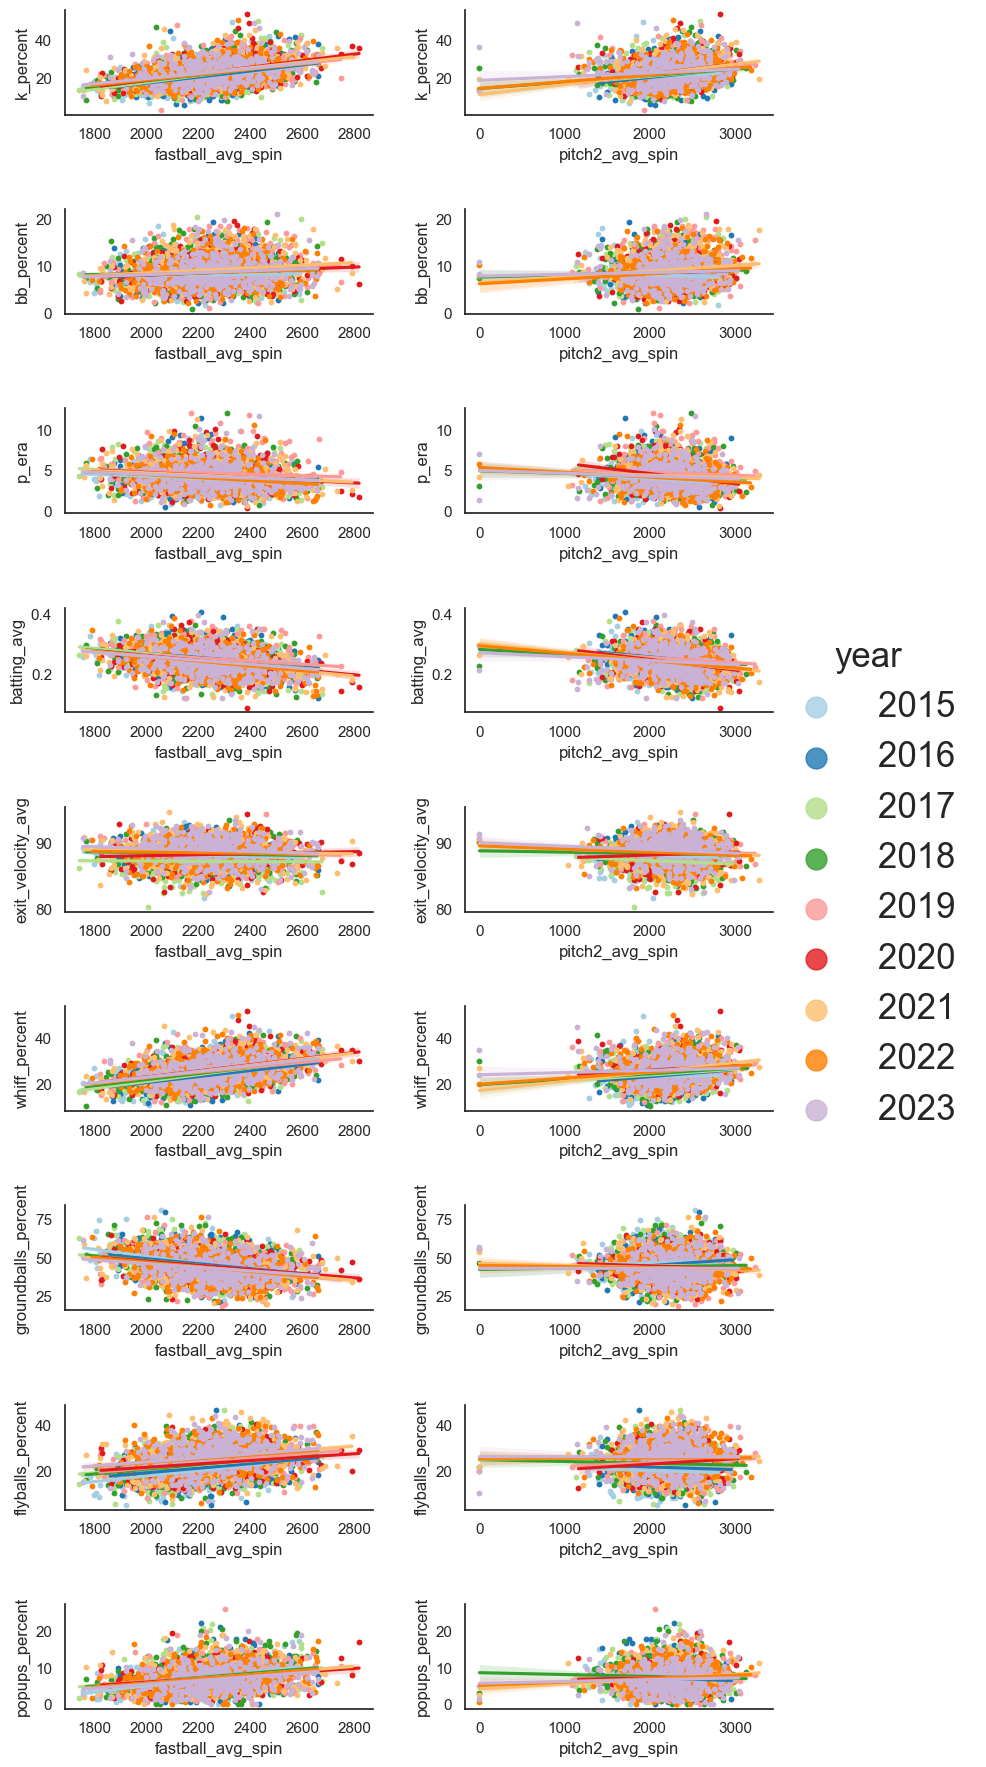

In [5]:
custom_palette=sns.color_palette("Paired",9)
sns.set_theme(style="white",palette=custom_palette)
plt.rc('legend',fontsize=25, title_fontsize=25,markerscale=5.0)
pp = sns.pairplot(data=data_spin_all,y_vars=["k_percent", "bb_percent", "p_era", "batting_avg","exit_velocity_avg", "whiff_percent", "groundballs_percent", "flyballs_percent", "popups_percent"],\
                  x_vars=["fastball_avg_spin", "pitch2_avg_spin"], kind='reg',markers='.',hue='year',height=2, aspect=2)
pp = pp.map(plt.scatter)
xlabels,ylabels = [],[]

handles = pp._legend_data.values()
labels = pp._legend_data.keys()
#pp.fig.legend(handles=handles, labels=labels)


for ax in pp.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in pp.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        pp.axes[j,i].xaxis.set_label_text(xlabels[i],visible=True)
        pp.axes[j,i].yaxis.set_label_text(ylabels[j],visible=True)

for ax in pp.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
plt.subplots_adjust(wspace=0.3, hspace=0.9)
plt.show()

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


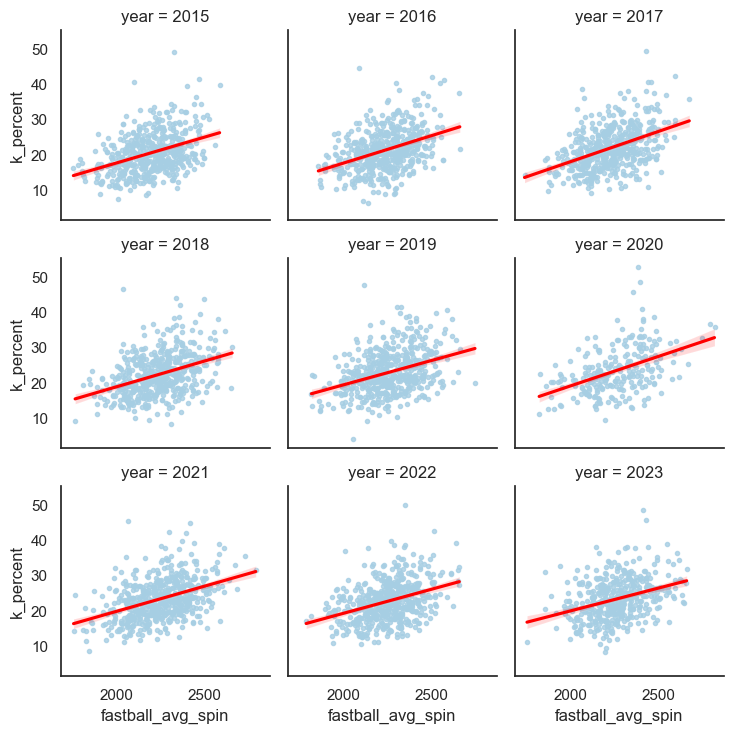

In [6]:
# drill down into a relationship across multiple years; this one is 'fastball_avg_spin' & k_percent'
sns.lmplot(x='fastball_avg_spin', y='k_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


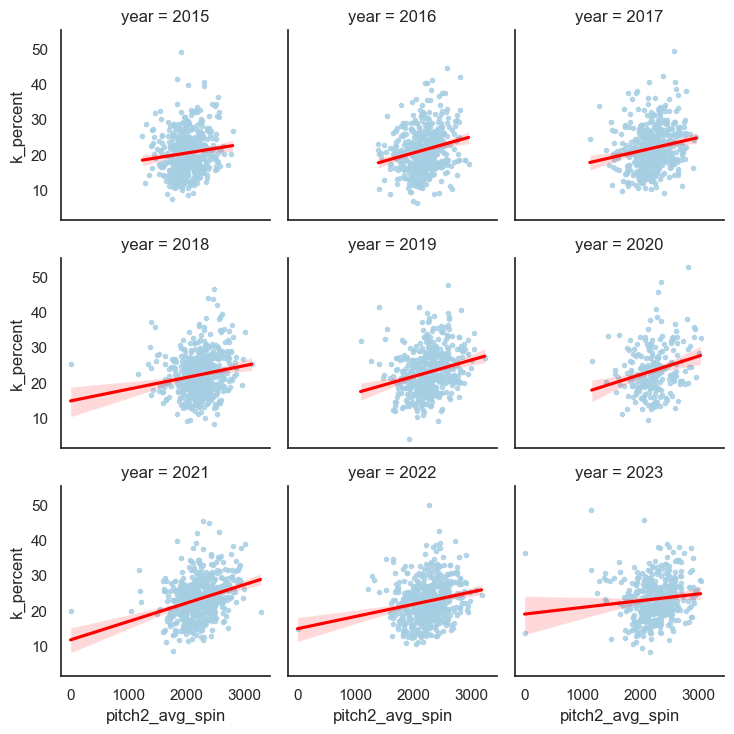

In [7]:
sns.lmplot(x='pitch2_avg_spin', y='k_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


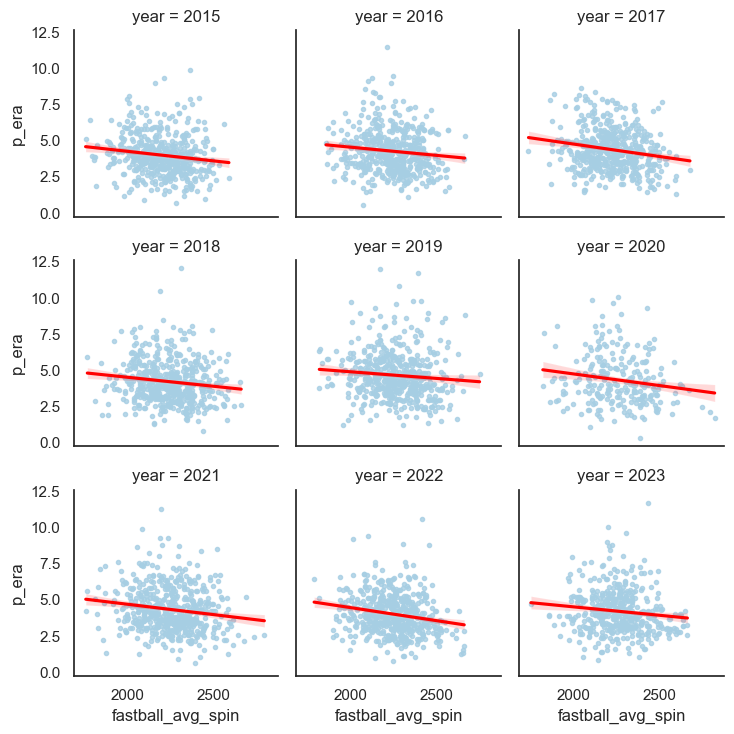

In [8]:
sns.lmplot(x='fastball_avg_spin', y='p_era', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


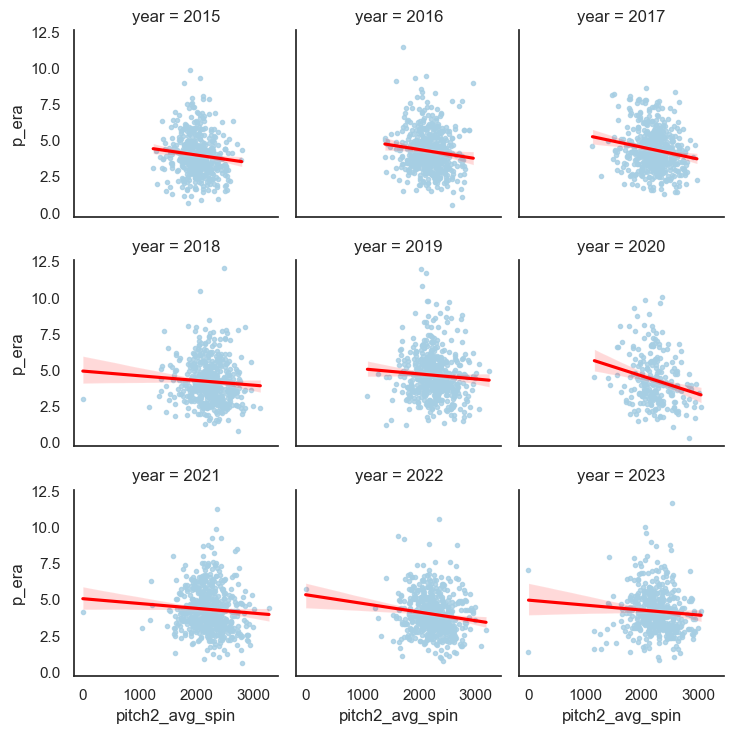

In [9]:
sns.lmplot(x='pitch2_avg_spin', y='p_era', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


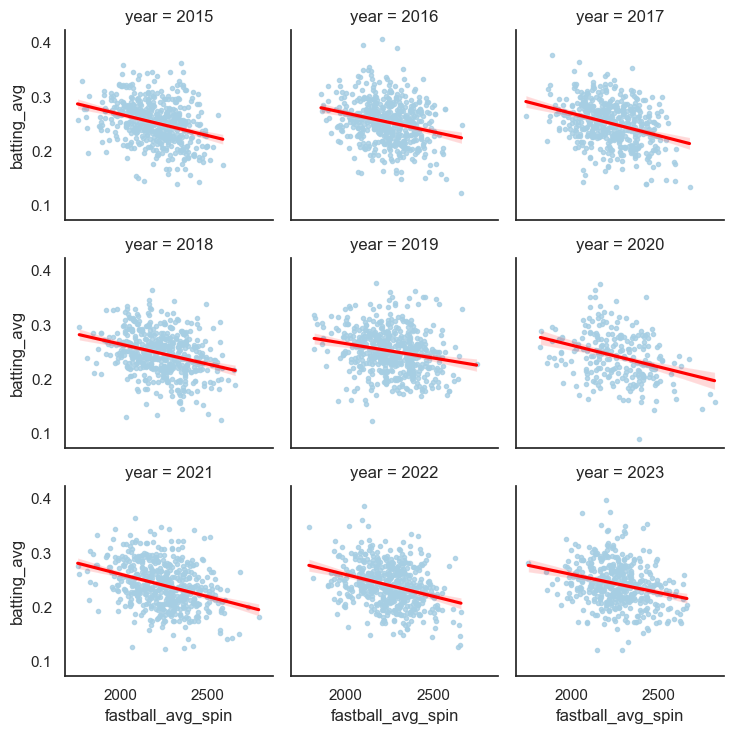

In [10]:
sns.lmplot(x='fastball_avg_spin', y='batting_avg', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


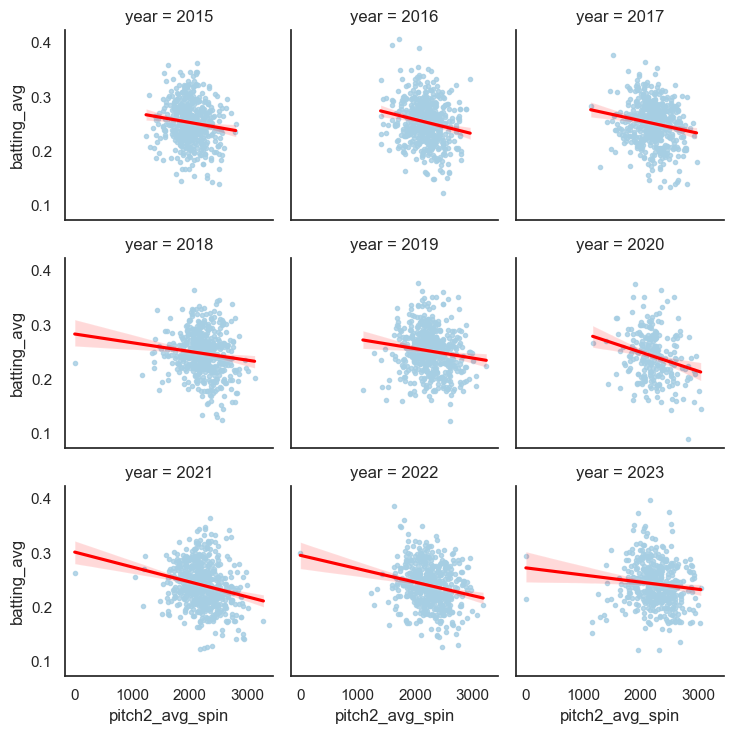

In [11]:
sns.lmplot(x='pitch2_avg_spin', y='batting_avg', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


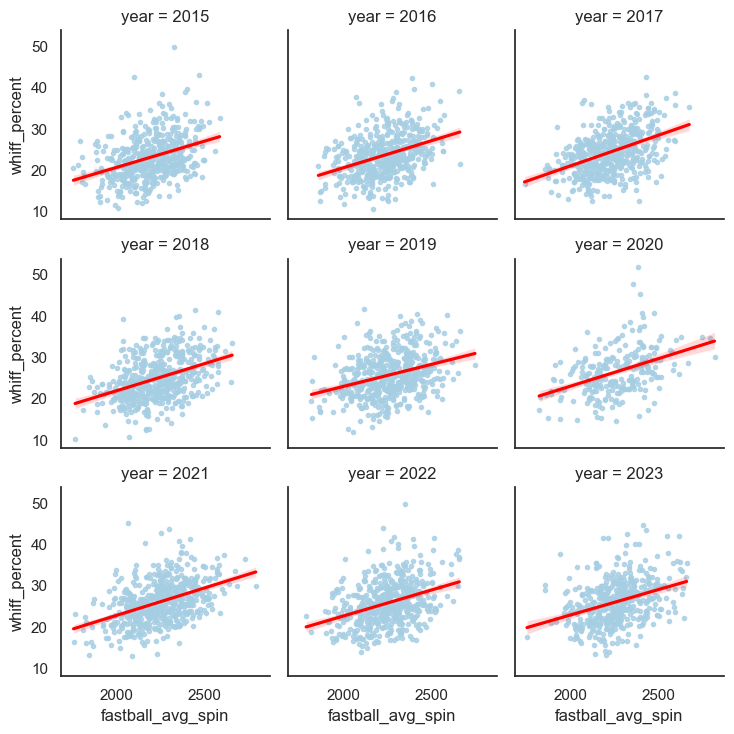

In [12]:
sns.lmplot(x='fastball_avg_spin', y='whiff_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

/Users/andrew/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


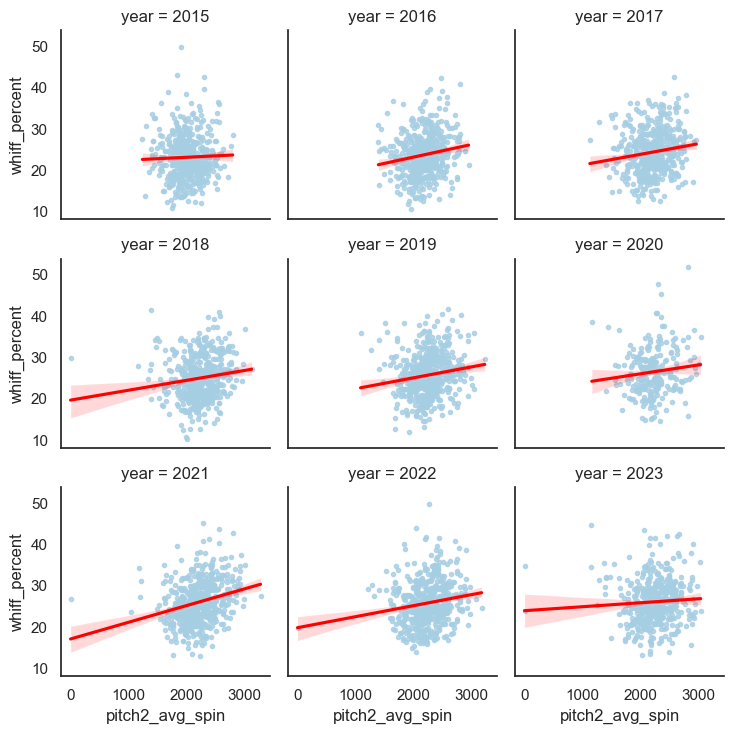

In [13]:
sns.lmplot(x='pitch2_avg_spin', y='whiff_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

In conclusion, based on the p-values and subsequent graphs throughout the years 2015-2023, there is a correlation between the change in both pitch type's spin and the change in opponent batting average, K%, BB%, ERA, Whiff Rate, flyball rate, and popup rate. With groundball rate, there is only a correlation with the fastball's average spin, and not the Pitch 2. 